# 모두의 딥러닝
## 19장 세상에 없는 얼굴 GAN, 오토인코더

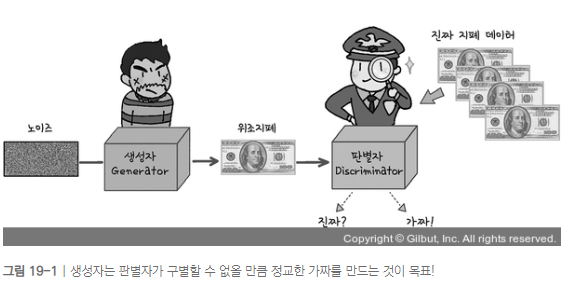

가짜를 만들어 내는 파트를 생성자(Generator) \
진위를 가려내는 파트를 판별자(Discriminator) \

진짜 지폐와 똑같은 위조지폐를 만들기 위해 애쓰는 위조지폐범과 \
이를 가려내기 위해 노력하는 경찰 사이의 경합이 \
결국 더 정교한 위조지폐를 만들어 낸다는 것이 \
적대적경합 (GAN 알고리즘 내부에서 일어나는 일들)

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models,layers

import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

In [2]:
# 생성자 모델을 만듬

generator = models.Sequential()

# LeakyReLU()는 0 밑으로 약간의 기울기를 넣어줄 수 있음
# 여기서는 임의로 0.2를 넣어줌
generator.add(layers.Dense(7*7*128, input_dim=100, 
                          activation=layers.LeakyReLU(0.2)))

# BatchNormalization()은 입력값을 0~1사이로 스케일링 해줌
# BatchNormalization()은 자체 파라미터가 있으므로 계산 놉
generator.add(layers.BatchNormalization())

generator.add(layers.Reshape((7, 7, 128)))

# UpSampling2D() 2배로 늘림
generator.add(layers.UpSampling2D())

# padding='same'은 7x7을 5x5로 줄일때 전체 크기는 7x7로 유지시킴
generator.add(layers.Conv2D(64, kernel_size=5, padding='same'))

generator.add(layers.BatchNormalization())

generator.add(layers.Activation(layers.LeakyReLU(0.2)))

generator.add(layers.UpSampling2D())

generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [3]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [4]:
# 가짜를 받는 판별자모델을 만듬

discriminator = models.Sequential()

# strides=2 커널 윈도를 두칸씩 이동 (디폴트는 1씩 이동)
discriminator.add(layers.Conv2D(64, kernel_size=5, strides=2, 
                         input_shape=(28,28,1), padding="same"))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))

# metrics=[]를 선언하지 않는 이유
# 판별자는 오차를 던져주기 위한 용도일뿐이기 때문에 최종결론을 표시해줄필요가없다
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# 기본 디폴트를 학습을 못하게 막음
# 판별자는 자신이 학습되지 않아야함 오직 판별만을 위한것
discriminator.trainable = False

In [5]:
# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듬

ginput = layers.Input(shape=(100,))
dis_output = discriminator(generator(ginput))

# Model(입력, 출력)
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [6]:
# 신경망을 실행시키는 함수를 만듬

if not os.path.exists('data/gan_images'):
    os.mkdir('data/gan_images')
    
def gan_train(epoch, batch_size, saving_interval):
    # 앞서 불러온 MNIST를 다시 이용함. 테스트 과정은 필요 없고
    # 이미지만 사용할 것이기 때문에 X_train만 호출
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    
    # 225로 나누는게 아닌 127.5를 먼저 빼주고 127.5로 나눔
    # 결과는 0~1이 아닌 -1 ~1 사이가 나옴
    # 왜 이렇게 했느냐?
    # 생성자가 출력 값을 activation='tanh' 즉 -1에서 1사이로 주었기 때문에
    # 판별자의 X_train 값도 맞춰줘야함
    X_train = (X_train - 127.5) / 127.5
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        # 실제 데이터를 판별자에 입력하는 부분
        # randint(a, b, c)는 a에서 b사이를 c만큼 랜덤으로 뽑으라는 함수
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        # 판별자가 가짜가 아닌 진짜그림을 판별할때의 오차
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        
        # 가상 이미지를 판별자에 입력하는 부분
        # 0에서 1사이에서 batch_size만큼 100열의 noise를
        # random이 아닌 정규식으로 뽑음
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        # 판별자가 가짜그림을 판별할때의 오차
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        # 판별자와 생성자의 오차를 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
        
        # 중간 과정을 이미지로 저장하는 부분 정해진 인터벌만큼 학습되면
        # 그때 만든 이미지를 gan_images 폴더에 저장하라는 의미
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("data/gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 155ms/step
epoch:0  d_loss:0.7335  g_loss:0.6730
1/1 [==============================] - 0s 34ms/step
epoch:1  d_loss:0.5218  g_loss:0.3825
1/1 [==============================] - 0s 36ms/step
epoch:2  d_loss:0.4663  g_loss:0.1197
1/1 [==============================] - 0s 31ms/step
epoch:3  d_loss:0.4820  g_loss:0.0412
1/1 [==============================] - 0s 32ms/step
epoch:4  d_loss:0.5424  g_loss:0.0344
1/1 [==============================] - 0s 30ms/step
epoch:5  d_loss:0.5183  g_loss:0.0830
1/1 [==============================] - 0s 16ms/step
epoch:6  d_loss:0.4851  g_loss:0.2162
1/1 [==============================] - 0s 37ms/step
epoch:7  d_loss:0.4479  g_loss:0.4509
1/1 [==============================] - 0s 31ms/step
epoch:8  d_loss:0.4636  g_loss:0.5948
1/1 [==============================] - 0s 39ms/step
epoch:9  d_loss:0.4652  g_loss:0.6345
1/1 [==============================] - 0s 28ms/step
epoch:10  d_loss:0.4476  g_loss:0.6461
1/1 [===

epoch:89  d_loss:0.5041  g_loss:1.1260
1/1 [==============================] - 0s 25ms/step
epoch:90  d_loss:0.5035  g_loss:0.9072
1/1 [==============================] - 0s 31ms/step
epoch:91  d_loss:0.3382  g_loss:1.5299
1/1 [==============================] - 0s 30ms/step
epoch:92  d_loss:0.3242  g_loss:1.3759
1/1 [==============================] - 0s 21ms/step
epoch:93  d_loss:0.3117  g_loss:2.0531
1/1 [==============================] - 0s 30ms/step
epoch:94  d_loss:0.2868  g_loss:2.1005
1/1 [==============================] - 0s 28ms/step
epoch:95  d_loss:0.3734  g_loss:1.8630
1/1 [==============================] - 0s 29ms/step
epoch:96  d_loss:0.3745  g_loss:2.3459
1/1 [==============================] - 0s 30ms/step
epoch:97  d_loss:0.3098  g_loss:2.3619
1/1 [==============================] - 0s 27ms/step
epoch:98  d_loss:0.4156  g_loss:2.5066
1/1 [==============================] - 0s 30ms/step
epoch:99  d_loss:0.5694  g_loss:2.4809
1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 37ms/step
epoch:179  d_loss:0.4768  g_loss:1.1324
1/1 [==============================] - 0s 51ms/step
epoch:180  d_loss:0.4596  g_loss:1.0635
1/1 [==============================] - 0s 23ms/step
epoch:181  d_loss:0.6588  g_loss:1.0257
1/1 [==============================] - 0s 31ms/step
epoch:182  d_loss:0.6325  g_loss:1.0484
1/1 [==============================] - 0s 31ms/step
epoch:183  d_loss:0.6607  g_loss:1.1358
1/1 [==============================] - 0s 30ms/step
epoch:184  d_loss:0.7295  g_loss:1.0575
1/1 [==============================] - 0s 31ms/step
epoch:185  d_loss:0.6426  g_loss:1.0941
1/1 [==============================] - 0s 29ms/step
epoch:186  d_loss:0.6020  g_loss:1.1059
1/1 [==============================] - 0s 30ms/step
epoch:187  d_loss:0.6793  g_loss:0.9382
1/1 [==============================] - 0s 19ms/step
epoch:188  d_loss:0.6170  g_loss:0.8528
1/1 [==============================] - 0s 28ms/step
epoch:189  d_loss:0.6083  g_

1/1 [==============================] - 0s 29ms/step
epoch:267  d_loss:0.6836  g_loss:1.3410
1/1 [==============================] - 0s 30ms/step
epoch:268  d_loss:0.5400  g_loss:1.4144
1/1 [==============================] - 0s 31ms/step
epoch:269  d_loss:0.4804  g_loss:1.5190
1/1 [==============================] - 0s 31ms/step
epoch:270  d_loss:0.5464  g_loss:1.3038
1/1 [==============================] - 0s 29ms/step
epoch:271  d_loss:0.4724  g_loss:1.3466
1/1 [==============================] - 0s 31ms/step
epoch:272  d_loss:0.4738  g_loss:1.4751
1/1 [==============================] - 0s 32ms/step
epoch:273  d_loss:0.3949  g_loss:1.5397
1/1 [==============================] - 0s 32ms/step
epoch:274  d_loss:0.3612  g_loss:1.8615
1/1 [==============================] - 0s 34ms/step
epoch:275  d_loss:0.2825  g_loss:2.5122
1/1 [==============================] - 0s 30ms/step
epoch:276  d_loss:0.3879  g_loss:2.6013
1/1 [==============================] - 0s 31ms/step
epoch:277  d_loss:0.3425  g_

1/1 [==============================] - 0s 30ms/step
epoch:356  d_loss:0.3578  g_loss:1.6203
1/1 [==============================] - 0s 27ms/step
epoch:357  d_loss:0.2972  g_loss:2.0765
1/1 [==============================] - 0s 30ms/step
epoch:358  d_loss:0.3423  g_loss:2.0476
1/1 [==============================] - 0s 30ms/step
epoch:359  d_loss:0.3648  g_loss:1.8198
1/1 [==============================] - 0s 19ms/step
epoch:360  d_loss:0.3446  g_loss:2.1697
1/1 [==============================] - 0s 30ms/step
epoch:361  d_loss:0.3500  g_loss:1.9347
1/1 [==============================] - 0s 32ms/step
epoch:362  d_loss:0.4165  g_loss:1.9537
1/1 [==============================] - 0s 23ms/step
epoch:363  d_loss:0.2860  g_loss:2.3132
1/1 [==============================] - 0s 30ms/step
epoch:364  d_loss:0.4039  g_loss:2.0188
1/1 [==============================] - 0s 26ms/step
epoch:365  d_loss:0.3036  g_loss:1.9665
1/1 [==============================] - 0s 25ms/step
epoch:366  d_loss:0.3690  g_

1/1 [==============================] - 0s 31ms/step
epoch:444  d_loss:0.3452  g_loss:1.8229
1/1 [==============================] - 0s 30ms/step
epoch:445  d_loss:0.3548  g_loss:1.5515
1/1 [==============================] - 0s 29ms/step
epoch:446  d_loss:0.2589  g_loss:1.6396
1/1 [==============================] - 0s 30ms/step
epoch:447  d_loss:0.3816  g_loss:1.6901
1/1 [==============================] - 0s 26ms/step
epoch:448  d_loss:0.2713  g_loss:1.9976
1/1 [==============================] - 0s 31ms/step
epoch:449  d_loss:0.3313  g_loss:2.1989
1/1 [==============================] - 0s 14ms/step
epoch:450  d_loss:0.3409  g_loss:2.2350
1/1 [==============================] - 0s 26ms/step
epoch:451  d_loss:0.3666  g_loss:2.5789
1/1 [==============================] - 0s 29ms/step
epoch:452  d_loss:0.3117  g_loss:1.9338
1/1 [==============================] - 0s 30ms/step
epoch:453  d_loss:0.3244  g_loss:1.5506
1/1 [==============================] - 0s 22ms/step
epoch:454  d_loss:0.3588  g_

1/1 [==============================] - 0s 32ms/step
epoch:533  d_loss:0.1185  g_loss:3.8718
1/1 [==============================] - 0s 31ms/step
epoch:534  d_loss:0.1382  g_loss:3.5302
1/1 [==============================] - 0s 32ms/step
epoch:535  d_loss:0.1334  g_loss:3.3160
1/1 [==============================] - 0s 32ms/step
epoch:536  d_loss:0.3005  g_loss:2.6982
1/1 [==============================] - 0s 31ms/step
epoch:537  d_loss:0.2109  g_loss:2.8952
1/1 [==============================] - 0s 18ms/step
epoch:538  d_loss:0.1893  g_loss:2.8940
1/1 [==============================] - 0s 33ms/step
epoch:539  d_loss:0.2887  g_loss:3.1546
1/1 [==============================] - 0s 28ms/step
epoch:540  d_loss:0.1384  g_loss:3.6302
1/1 [==============================] - 0s 30ms/step
epoch:541  d_loss:0.1443  g_loss:4.2557
1/1 [==============================] - 0s 46ms/step
epoch:542  d_loss:0.2997  g_loss:4.3328
1/1 [==============================] - 0s 54ms/step
epoch:543  d_loss:0.2566  g_

1/1 [==============================] - 0s 30ms/step
epoch:621  d_loss:0.3996  g_loss:1.9012
1/1 [==============================] - 0s 17ms/step
epoch:622  d_loss:0.3683  g_loss:1.6482
1/1 [==============================] - 0s 30ms/step
epoch:623  d_loss:0.2537  g_loss:1.6646
1/1 [==============================] - 0s 33ms/step
epoch:624  d_loss:0.4235  g_loss:1.7181
1/1 [==============================] - 0s 22ms/step
epoch:625  d_loss:0.4147  g_loss:1.8512
1/1 [==============================] - 0s 36ms/step
epoch:626  d_loss:0.4070  g_loss:2.0622
1/1 [==============================] - 0s 31ms/step
epoch:627  d_loss:0.4887  g_loss:1.4628
1/1 [==============================] - 0s 16ms/step
epoch:628  d_loss:0.3893  g_loss:1.7940
1/1 [==============================] - 0s 20ms/step
epoch:629  d_loss:0.5216  g_loss:1.5160
1/1 [==============================] - 0s 30ms/step
epoch:630  d_loss:0.3072  g_loss:1.8652
1/1 [==============================] - 0s 29ms/step
epoch:631  d_loss:0.3427  g_

1/1 [==============================] - 0s 30ms/step
epoch:710  d_loss:0.4780  g_loss:1.8584
1/1 [==============================] - 0s 30ms/step
epoch:711  d_loss:0.4671  g_loss:2.0530
1/1 [==============================] - 0s 17ms/step
epoch:712  d_loss:0.5456  g_loss:2.1305
1/1 [==============================] - 0s 16ms/step
epoch:713  d_loss:0.4695  g_loss:2.2466
1/1 [==============================] - 0s 30ms/step
epoch:714  d_loss:0.4788  g_loss:1.7561
1/1 [==============================] - 0s 31ms/step
epoch:715  d_loss:0.4410  g_loss:2.0554
1/1 [==============================] - 0s 27ms/step
epoch:716  d_loss:0.4729  g_loss:2.2233
1/1 [==============================] - 0s 31ms/step
epoch:717  d_loss:0.4889  g_loss:2.4558
1/1 [==============================] - 0s 20ms/step
epoch:718  d_loss:0.5423  g_loss:2.1970
1/1 [==============================] - 0s 24ms/step
epoch:719  d_loss:0.4433  g_loss:2.4237
1/1 [==============================] - 0s 30ms/step
epoch:720  d_loss:0.6489  g_

1/1 [==============================] - 0s 31ms/step
epoch:799  d_loss:0.3464  g_loss:2.0763
1/1 [==============================] - 0s 30ms/step
epoch:800  d_loss:0.4196  g_loss:2.0566
1/1 [==============================] - 0s 31ms/step
epoch:801  d_loss:0.3578  g_loss:2.4065
1/1 [==============================] - 0s 31ms/step
epoch:802  d_loss:0.2862  g_loss:2.2422
1/1 [==============================] - 0s 30ms/step
epoch:803  d_loss:0.4631  g_loss:2.0901
1/1 [==============================] - 0s 29ms/step
epoch:804  d_loss:0.3779  g_loss:1.7873
1/1 [==============================] - 0s 30ms/step
epoch:805  d_loss:0.3841  g_loss:1.7147
1/1 [==============================] - 0s 30ms/step
epoch:806  d_loss:0.3102  g_loss:1.7822
1/1 [==============================] - 0s 41ms/step
epoch:807  d_loss:0.3165  g_loss:2.2199
1/1 [==============================] - 0s 16ms/step
epoch:808  d_loss:0.2089  g_loss:2.4700
1/1 [==============================] - 0s 28ms/step
epoch:809  d_loss:0.2296  g_

1/1 [==============================] - 0s 28ms/step
epoch:887  d_loss:0.4434  g_loss:1.8745
1/1 [==============================] - 0s 17ms/step
epoch:888  d_loss:0.4113  g_loss:1.9078
1/1 [==============================] - 0s 31ms/step
epoch:889  d_loss:0.5391  g_loss:1.4973
1/1 [==============================] - 0s 31ms/step
epoch:890  d_loss:0.4120  g_loss:1.8900
1/1 [==============================] - 0s 31ms/step
epoch:891  d_loss:0.3536  g_loss:1.7367
1/1 [==============================] - 0s 30ms/step
epoch:892  d_loss:0.3026  g_loss:1.5784
1/1 [==============================] - 0s 15ms/step
epoch:893  d_loss:0.2997  g_loss:1.6399
1/1 [==============================] - 0s 21ms/step
epoch:894  d_loss:0.3906  g_loss:1.5080
1/1 [==============================] - 0s 30ms/step
epoch:895  d_loss:0.1934  g_loss:2.0134
1/1 [==============================] - 0s 27ms/step
epoch:896  d_loss:0.2074  g_loss:2.3477
1/1 [==============================] - 0s 28ms/step
epoch:897  d_loss:0.3094  g_

1/1 [==============================] - 0s 30ms/step
epoch:976  d_loss:0.3276  g_loss:2.7969
1/1 [==============================] - 0s 30ms/step
epoch:977  d_loss:0.2540  g_loss:2.7635
1/1 [==============================] - 0s 30ms/step
epoch:978  d_loss:0.3392  g_loss:2.5575
1/1 [==============================] - 0s 24ms/step
epoch:979  d_loss:0.5514  g_loss:2.4209
1/1 [==============================] - 0s 27ms/step
epoch:980  d_loss:0.2563  g_loss:2.6446
1/1 [==============================] - 0s 31ms/step
epoch:981  d_loss:0.3741  g_loss:3.0214
1/1 [==============================] - 0s 16ms/step
epoch:982  d_loss:0.5690  g_loss:2.5028
1/1 [==============================] - 0s 22ms/step
epoch:983  d_loss:0.3699  g_loss:3.0185
1/1 [==============================] - 0s 25ms/step
epoch:984  d_loss:0.3880  g_loss:2.7479
1/1 [==============================] - 0s 30ms/step
epoch:985  d_loss:0.2664  g_loss:2.3636
1/1 [==============================] - 0s 31ms/step
epoch:986  d_loss:0.4009  g_

1/1 [==============================] - 0s 32ms/step
epoch:1064  d_loss:0.3329  g_loss:2.4359
1/1 [==============================] - 0s 26ms/step
epoch:1065  d_loss:0.2639  g_loss:2.8539
1/1 [==============================] - 0s 31ms/step
epoch:1066  d_loss:0.2492  g_loss:2.6817
1/1 [==============================] - 0s 22ms/step
epoch:1067  d_loss:0.3219  g_loss:2.7627
1/1 [==============================] - 0s 30ms/step
epoch:1068  d_loss:0.4369  g_loss:2.2343
1/1 [==============================] - 0s 29ms/step
epoch:1069  d_loss:0.1886  g_loss:2.2333
1/1 [==============================] - 0s 15ms/step
epoch:1070  d_loss:0.4136  g_loss:2.0881
1/1 [==============================] - 0s 29ms/step
epoch:1071  d_loss:0.4092  g_loss:1.7739
1/1 [==============================] - 0s 25ms/step
epoch:1072  d_loss:0.3068  g_loss:2.2342
1/1 [==============================] - 0s 23ms/step
epoch:1073  d_loss:0.2168  g_loss:2.4782
1/1 [==============================] - 0s 29ms/step
epoch:1074  d_loss

1/1 [==============================] - 0s 26ms/step
epoch:1152  d_loss:0.3699  g_loss:2.3976
1/1 [==============================] - 0s 24ms/step
epoch:1153  d_loss:0.3406  g_loss:2.3457
1/1 [==============================] - 0s 23ms/step
epoch:1154  d_loss:0.3177  g_loss:2.4319
1/1 [==============================] - 0s 30ms/step
epoch:1155  d_loss:0.3420  g_loss:1.5713
1/1 [==============================] - 0s 30ms/step
epoch:1156  d_loss:0.3116  g_loss:2.0045
1/1 [==============================] - 0s 26ms/step
epoch:1157  d_loss:0.3081  g_loss:2.2620
1/1 [==============================] - 0s 27ms/step
epoch:1158  d_loss:0.2917  g_loss:2.4236
1/1 [==============================] - 0s 31ms/step
epoch:1159  d_loss:0.3383  g_loss:2.3814
1/1 [==============================] - 0s 29ms/step
epoch:1160  d_loss:0.3755  g_loss:2.4694
1/1 [==============================] - 0s 30ms/step
epoch:1161  d_loss:0.3102  g_loss:2.4977
1/1 [==============================] - 0s 29ms/step
epoch:1162  d_loss

epoch:1239  d_loss:0.3542  g_loss:2.2747
1/1 [==============================] - 0s 25ms/step
epoch:1240  d_loss:0.3534  g_loss:2.4319
1/1 [==============================] - 0s 31ms/step
epoch:1241  d_loss:0.4213  g_loss:2.4037
1/1 [==============================] - 0s 28ms/step
epoch:1242  d_loss:0.2630  g_loss:2.2393
1/1 [==============================] - 0s 30ms/step
epoch:1243  d_loss:0.4285  g_loss:2.2051
1/1 [==============================] - 0s 30ms/step
epoch:1244  d_loss:0.4909  g_loss:1.6018
1/1 [==============================] - 0s 28ms/step
epoch:1245  d_loss:0.3623  g_loss:1.6464
1/1 [==============================] - 0s 28ms/step
epoch:1246  d_loss:0.4956  g_loss:1.6661
1/1 [==============================] - 0s 33ms/step
epoch:1247  d_loss:0.2099  g_loss:2.5270
1/1 [==============================] - 0s 32ms/step
epoch:1248  d_loss:0.3011  g_loss:2.7437
1/1 [==============================] - 0s 32ms/step
epoch:1249  d_loss:0.2708  g_loss:2.8258
1/1 [========================

1/1 [==============================] - 0s 34ms/step
epoch:1328  d_loss:0.5110  g_loss:1.7460
1/1 [==============================] - 0s 29ms/step
epoch:1329  d_loss:0.4110  g_loss:1.7135
1/1 [==============================] - 0s 19ms/step
epoch:1330  d_loss:0.4530  g_loss:1.8057
1/1 [==============================] - 0s 23ms/step
epoch:1331  d_loss:0.4302  g_loss:1.6885
1/1 [==============================] - 0s 30ms/step
epoch:1332  d_loss:0.5792  g_loss:1.8402
1/1 [==============================] - 0s 27ms/step
epoch:1333  d_loss:0.5936  g_loss:1.3062
1/1 [==============================] - 0s 35ms/step
epoch:1334  d_loss:0.5624  g_loss:2.1093
1/1 [==============================] - 0s 30ms/step
epoch:1335  d_loss:0.4373  g_loss:2.2244
1/1 [==============================] - 0s 29ms/step
epoch:1336  d_loss:0.3703  g_loss:1.9760
1/1 [==============================] - 0s 14ms/step
epoch:1337  d_loss:0.4606  g_loss:1.7701
1/1 [==============================] - 0s 31ms/step
epoch:1338  d_loss

epoch:1415  d_loss:0.3381  g_loss:2.1111
1/1 [==============================] - 0s 16ms/step
epoch:1416  d_loss:0.3781  g_loss:2.0812
1/1 [==============================] - 0s 30ms/step
epoch:1417  d_loss:0.3275  g_loss:2.2144
1/1 [==============================] - 0s 30ms/step
epoch:1418  d_loss:0.2864  g_loss:2.2953
1/1 [==============================] - 0s 26ms/step
epoch:1419  d_loss:0.3564  g_loss:2.5121
1/1 [==============================] - 0s 31ms/step
epoch:1420  d_loss:0.3198  g_loss:2.5750
1/1 [==============================] - 0s 31ms/step
epoch:1421  d_loss:0.3923  g_loss:2.5057
1/1 [==============================] - 0s 34ms/step
epoch:1422  d_loss:0.3293  g_loss:1.9606
1/1 [==============================] - 0s 15ms/step
epoch:1423  d_loss:0.3128  g_loss:2.2850
1/1 [==============================] - 0s 17ms/step
epoch:1424  d_loss:0.4178  g_loss:1.8690
1/1 [==============================] - 0s 30ms/step
epoch:1425  d_loss:0.3401  g_loss:1.9839
1/1 [========================

1/1 [==============================] - 0s 36ms/step
epoch:1504  d_loss:0.4483  g_loss:1.6840
1/1 [==============================] - 0s 32ms/step
epoch:1505  d_loss:0.3621  g_loss:1.6881
1/1 [==============================] - 0s 35ms/step
epoch:1506  d_loss:0.4399  g_loss:1.8844
1/1 [==============================] - 0s 35ms/step
epoch:1507  d_loss:0.4955  g_loss:1.7353
1/1 [==============================] - 0s 31ms/step
epoch:1508  d_loss:0.4974  g_loss:2.1721
1/1 [==============================] - 0s 31ms/step
epoch:1509  d_loss:0.5306  g_loss:2.0019
1/1 [==============================] - 0s 42ms/step
epoch:1510  d_loss:0.5641  g_loss:1.8715
1/1 [==============================] - 0s 38ms/step
epoch:1511  d_loss:0.6912  g_loss:1.4374
1/1 [==============================] - 0s 30ms/step
epoch:1512  d_loss:0.6367  g_loss:1.6920
1/1 [==============================] - 0s 32ms/step
epoch:1513  d_loss:0.3920  g_loss:2.1391
1/1 [==============================] - 0s 30ms/step
epoch:1514  d_loss

1/1 [==============================] - 0s 28ms/step
epoch:1592  d_loss:0.5709  g_loss:1.5539
1/1 [==============================] - 0s 16ms/step
epoch:1593  d_loss:0.4128  g_loss:1.6994
1/1 [==============================] - 0s 30ms/step
epoch:1594  d_loss:0.5189  g_loss:2.2509
1/1 [==============================] - 0s 25ms/step
epoch:1595  d_loss:0.4394  g_loss:2.3402
1/1 [==============================] - 0s 25ms/step
epoch:1596  d_loss:0.3535  g_loss:2.4894
1/1 [==============================] - 0s 32ms/step
epoch:1597  d_loss:0.5174  g_loss:2.3481
1/1 [==============================] - 0s 32ms/step
epoch:1598  d_loss:0.6306  g_loss:1.1437
1/1 [==============================] - 0s 46ms/step
epoch:1599  d_loss:0.4274  g_loss:1.2673
1/1 [==============================] - 0s 43ms/step
epoch:1600  d_loss:0.4667  g_loss:1.6160
1/1 [==============================] - 0s 64ms/step
epoch:1601  d_loss:0.5715  g_loss:1.5634
1/1 [==============================] - 0s 39ms/step
epoch:1602  d_loss

epoch:1679  d_loss:0.5853  g_loss:1.3793
1/1 [==============================] - 0s 20ms/step
epoch:1680  d_loss:0.3486  g_loss:1.7685
1/1 [==============================] - 0s 24ms/step
epoch:1681  d_loss:0.4338  g_loss:1.5713
1/1 [==============================] - 0s 47ms/step
epoch:1682  d_loss:0.4831  g_loss:1.4874
1/1 [==============================] - 0s 31ms/step
epoch:1683  d_loss:0.3614  g_loss:1.9763
1/1 [==============================] - 0s 31ms/step
epoch:1684  d_loss:0.4287  g_loss:1.7597
1/1 [==============================] - 0s 31ms/step
epoch:1685  d_loss:0.4483  g_loss:2.0939
1/1 [==============================] - 0s 40ms/step
epoch:1686  d_loss:0.6474  g_loss:2.1686
1/1 [==============================] - 0s 45ms/step
epoch:1687  d_loss:0.4755  g_loss:1.7611
1/1 [==============================] - 0s 31ms/step
epoch:1688  d_loss:0.4135  g_loss:1.6997
1/1 [==============================] - 0s 16ms/step
epoch:1689  d_loss:0.3769  g_loss:1.7914
1/1 [========================

1/1 [==============================] - 0s 17ms/step
epoch:1768  d_loss:0.5456  g_loss:1.8340
1/1 [==============================] - 0s 29ms/step
epoch:1769  d_loss:0.4311  g_loss:2.0799
1/1 [==============================] - 0s 31ms/step
epoch:1770  d_loss:0.5633  g_loss:1.8003
1/1 [==============================] - 0s 29ms/step
epoch:1771  d_loss:0.4385  g_loss:1.7823
1/1 [==============================] - 0s 25ms/step
epoch:1772  d_loss:0.4542  g_loss:1.7474
1/1 [==============================] - 0s 16ms/step
epoch:1773  d_loss:0.5279  g_loss:1.8039
1/1 [==============================] - 0s 28ms/step
epoch:1774  d_loss:0.4798  g_loss:1.8818
1/1 [==============================] - 0s 55ms/step
epoch:1775  d_loss:0.4394  g_loss:1.9418
1/1 [==============================] - 0s 31ms/step
epoch:1776  d_loss:0.5837  g_loss:1.4543
1/1 [==============================] - 0s 26ms/step
epoch:1777  d_loss:0.5578  g_loss:1.6392
1/1 [==============================] - 0s 30ms/step
epoch:1778  d_loss

epoch:1855  d_loss:0.4539  g_loss:1.7709
1/1 [==============================] - 0s 29ms/step
epoch:1856  d_loss:0.4264  g_loss:1.8310
1/1 [==============================] - 0s 25ms/step
epoch:1857  d_loss:0.3838  g_loss:2.0435
1/1 [==============================] - 0s 42ms/step
epoch:1858  d_loss:0.4092  g_loss:1.9727
1/1 [==============================] - 0s 48ms/step
epoch:1859  d_loss:0.3449  g_loss:2.1596
1/1 [==============================] - 0s 36ms/step
epoch:1860  d_loss:0.4898  g_loss:1.7000
1/1 [==============================] - 0s 21ms/step
epoch:1861  d_loss:0.3881  g_loss:1.6623
1/1 [==============================] - 0s 19ms/step
epoch:1862  d_loss:0.2925  g_loss:1.9835
1/1 [==============================] - 0s 31ms/step
epoch:1863  d_loss:0.5251  g_loss:1.4474
1/1 [==============================] - 0s 25ms/step
epoch:1864  d_loss:0.5070  g_loss:2.1104
1/1 [==============================] - 0s 20ms/step
epoch:1865  d_loss:0.3720  g_loss:1.9381
1/1 [========================

1/1 [==============================] - 0s 38ms/step
epoch:1944  d_loss:0.5271  g_loss:1.6642
1/1 [==============================] - 0s 32ms/step
epoch:1945  d_loss:0.4147  g_loss:2.0363
1/1 [==============================] - 0s 39ms/step
epoch:1946  d_loss:0.4070  g_loss:2.0058
1/1 [==============================] - 0s 40ms/step
epoch:1947  d_loss:0.4920  g_loss:1.6950
1/1 [==============================] - 0s 29ms/step
epoch:1948  d_loss:0.5234  g_loss:1.5063
1/1 [==============================] - 0s 30ms/step
epoch:1949  d_loss:0.4463  g_loss:1.3374
1/1 [==============================] - 0s 29ms/step
epoch:1950  d_loss:0.5858  g_loss:1.5417
1/1 [==============================] - 0s 29ms/step
epoch:1951  d_loss:0.4738  g_loss:1.5583
1/1 [==============================] - 0s 32ms/step
epoch:1952  d_loss:0.4803  g_loss:1.8069
1/1 [==============================] - 0s 30ms/step
epoch:1953  d_loss:0.4544  g_loss:1.7908
1/1 [==============================] - 0s 31ms/step
epoch:1954  d_loss

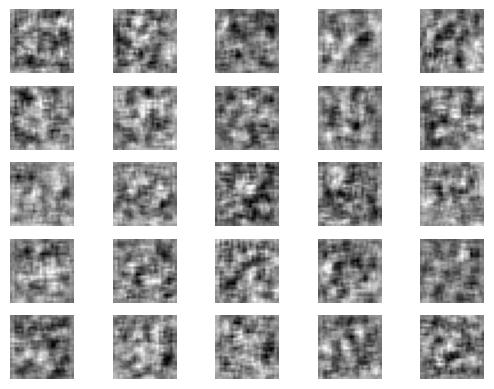

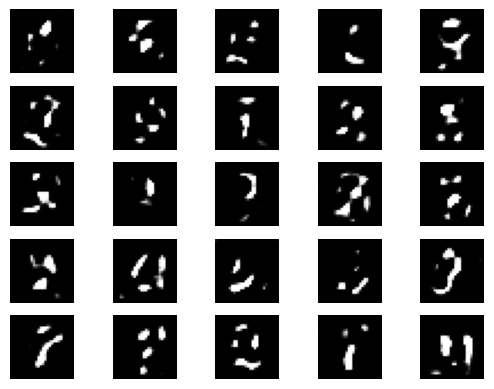

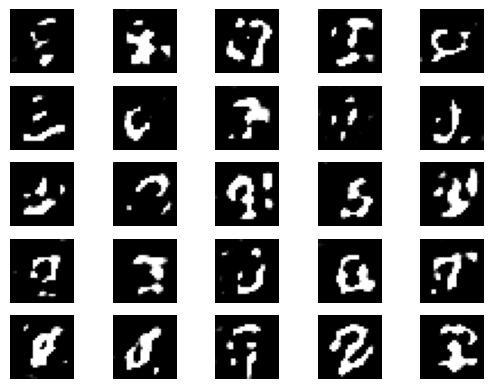

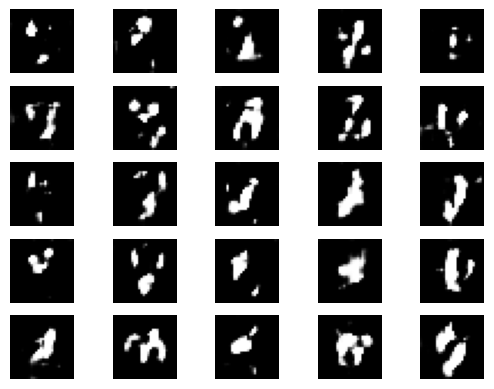

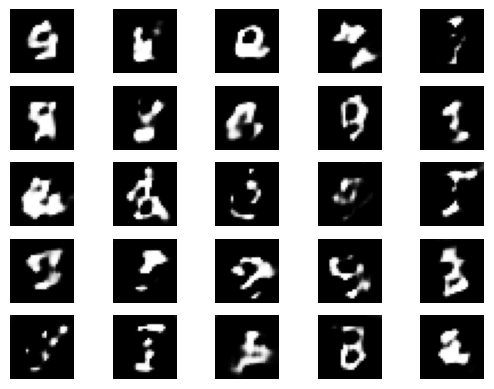

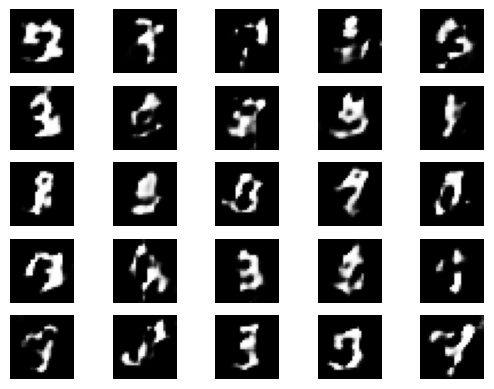

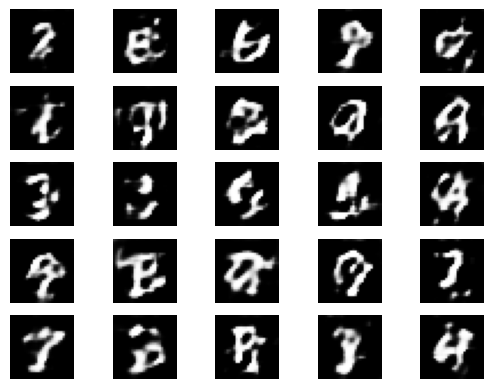

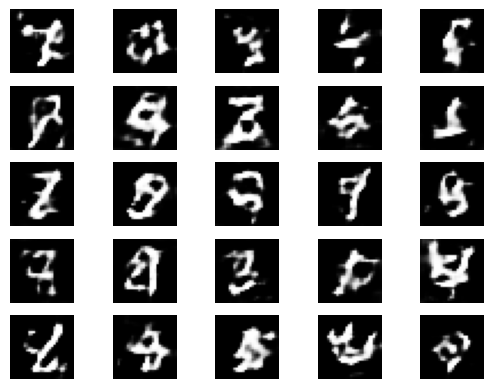

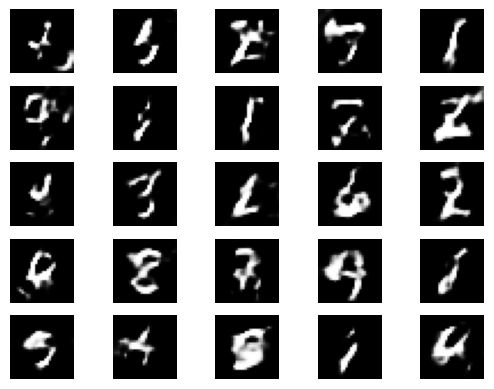

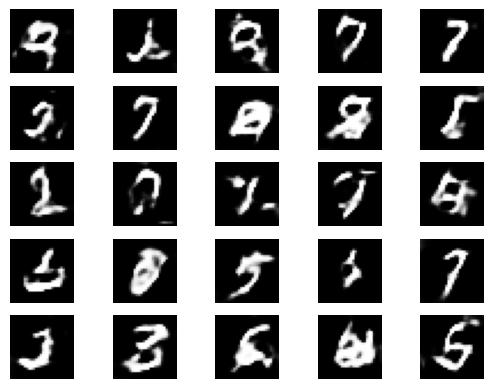

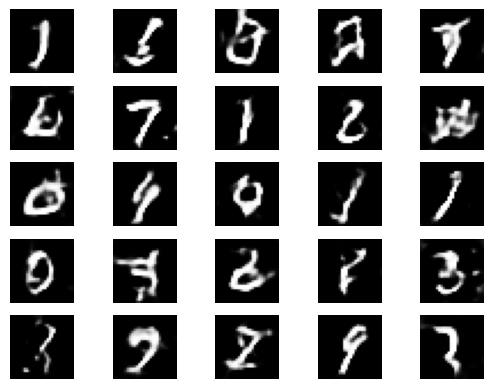

In [7]:
# 2000번 반복되고(+1을 하는 것에 주의)
# 배치 크기는 32, 200번마다 결과가 저장
gan_train(2001, 32, 200)